In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image1_path = "pano_image2.jpg"
image2_path = "pano_image1.jpg"

img1 = cv2.imread(image1_path, cv2.IMREAD_COLOR)
img2 = cv2.imread(image2_path, cv2.IMREAD_COLOR)

In [29]:
def find_good_matches(img1, img2, ratio_threshold=0.5, top_n_matches=50):

    # Convert to grayscale (required for SIFT)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Use BFMatcher with k=2
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test as per Lowe's paper
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)
        if len(good_matches) == top_n_matches:
            break

    return keypoints1 , keypoints2 , good_matches


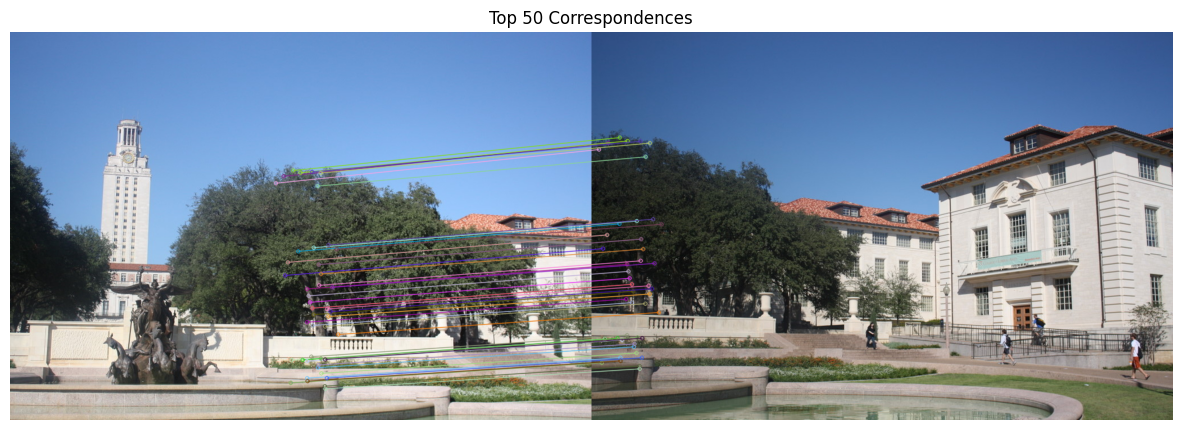

In [30]:
keypoints1 , keypoints2 , good_matches = find_good_matches(img1, img2)

# To draw and display the matches:
img_matches = cv2.drawMatches(
    img1, keypoints1, img2, keypoints2, good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Top 50 Correspondences')
plt.show()

In [31]:
def compute_homography(points_src, points_dst):
    
    if(not(len(points_src) == len(points_dst) and len(points_src) >= 4)):
        print('Need at least 4 pair of points')
        return 

    n = len(points_src)
    A = []

    for i in range(n):
        x, y = points_src[i]
        x_prime, y_prime = points_dst[i]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]  # Solution is the last row of Vt
    H = h.reshape(3, 3)

    # Ensure H(3,3) is 1 by normalizing
    H /= H[2, 2]  # Normalize to make H(3,3) = 1

    return H

In [32]:
def apply_homography(H, points):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed =  np.dot(H, points_homogeneous.T)
    transformed /= transformed[2, :]  # Normalize by the third coordinate
    return transformed[:2, :].T

Computed Homography Matrix:
[[ 1.35059089e+00 -8.10199718e-02 -5.95823141e+02]
 [ 1.97898033e-01  1.25048024e+00 -1.84549652e+02]
 [ 3.49124112e-04  7.82145742e-06  1.00000000e+00]]


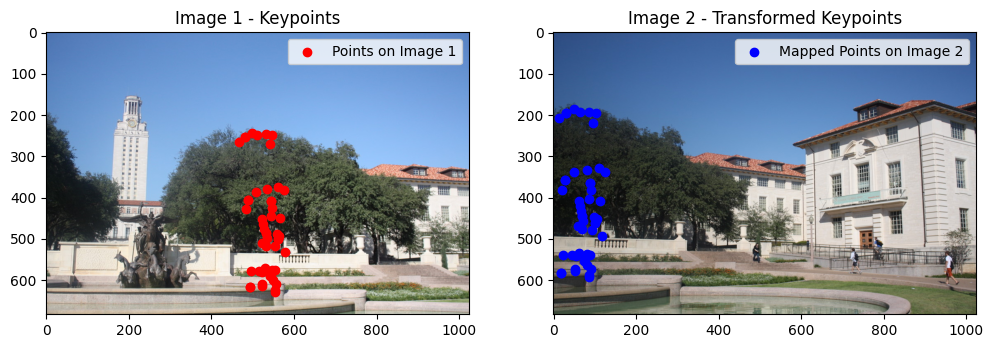

In [33]:
# Extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Compute the homography matrix using the function
H = compute_homography(pts1, pts2)
print("Computed Homography Matrix:")
print(H)

# Apply the homography to transform points from the first image to the second image
transformed_pts = apply_homography(H, pts1)

# Visualize the results: plot the points on both images
plt.figure(figsize=(12, 6))

# Show Image 1 with points
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.scatter(pts1[:, 0], pts1[:, 1], color='red', label='Points on Image 1')
plt.title('Image 1 - Keypoints')
plt.legend()

# Show Image 2 with the transformed points (from Image 1)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.scatter(transformed_pts[:, 0], transformed_pts[:, 1], color='blue', label='Mapped Points on Image 2')
plt.title('Image 2 - Transformed Keypoints')
plt.legend()
plt.show()



In [34]:
def forward_warp_image(image, H):
    
    # Get the dimensions of the input image
    height, width = image.shape[:2]

    # Compute the corners of the input image
    corners = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=float)
    ones = np.ones((corners.shape[0], 1))
    corners_homogeneous = np.hstack([corners, ones])  # Convert to homogeneous coordinates

    # Apply the homography to the corners to find the bounding box of the warped image
    transformed_corners = np.dot(H, corners_homogeneous.T).T
    transformed_corners /= transformed_corners[:, 2].reshape(-1, 1)  # Normalize by the third coordinate

    # Get the min and max coordinates
    min_x = int(np.floor(min(transformed_corners[:, 0])))
    max_x = int(np.ceil(max(transformed_corners[:, 0])))
    min_y = int(np.floor(min(transformed_corners[:, 1])))
    max_y = int(np.ceil(max(transformed_corners[:, 1])))

    # Compute the dimensions of the new image
    output_width = max_x - min_x
    output_height = max_y - min_y

    # Create an empty output image with a black background
    warped_image = np.zeros((output_height, output_width, 3), dtype=image.dtype)

    # Iterate through each pixel in the input image and map it to the output image
    for y in range(height):
        for x in range(width):
            # Input pixel in homogeneous coordinates
            input_pixel = np.array([x, y, 1])
            
            # Map the pixel using the homography matrix
            mapped_pixel = np.dot(H, input_pixel)
            mapped_pixel /= mapped_pixel[2]  # Normalize to get (x, y) coordinates

            # Compute the coordinates in the output image
            new_x = int(mapped_pixel[0] - min_x)
            new_y = int(mapped_pixel[1] - min_y)

            # Ensure the new coordinates are within bounds
            if 0 <= new_x < output_width and 0 <= new_y < output_height:
                warped_image[new_y, new_x] = image[y, x]

    return warped_image

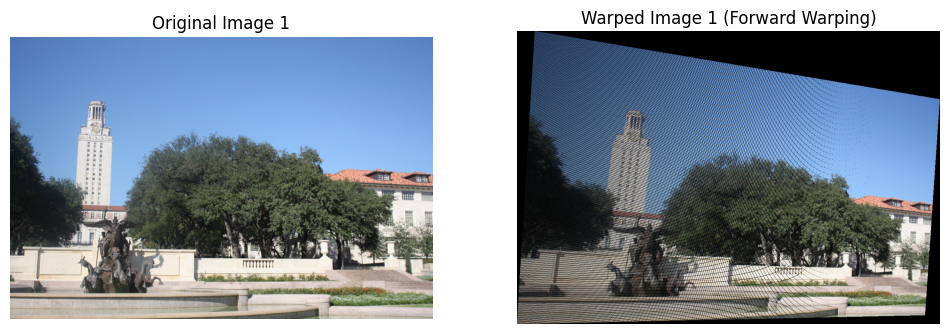

In [35]:
warped_img1 = forward_warp_image(img1, H)

# Show the original and warped images
plt.figure(figsize=(12, 6))

# Show the original Image 1
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')
plt.axis('off')

# Show the warped image with holes
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
plt.title('Warped Image 1 (Forward Warping)')
plt.axis('off')

plt.show()


In [ ]:
def bilinear_interpolation(image, x, y):
    # Get the integer coordinates of the four surrounding pixels 
    # by ceiling and flooring
    x1, y1 = int(x), int(y) #floor
    x2, y2 = min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1) #ceil
    
    
    # Calculate the weights for interpolation
    dx = x - x1
    dy = y - y1

    # Get the pixel values for the four neighbors
    I11 = image[y1, x1]
    I12 = image[y1, x2]
    I21 = image[y2, x1]
    I22 = image[y2, x2]

    # Perform the interpolation
    interpolated_value = (1 - dx) * (1 - dy) * I11 + dx * (1 - dy) * I12 + (1 - dx) * dy * I21 + dx * dy * I22
    return interpolated_value

In [37]:
def inverse_warp_image(image, H):

    # Get the dimensions of the input image
    height, width = image.shape[:2]

    # Compute the corners of the image to calculate the required output size
    corners = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=float)
    ones = np.ones((corners.shape[0], 1))
    corners_homogeneous = np.hstack([corners, ones])  # Convert to homogeneous coordinates

    # Apply the homography to the corners to find the bounding box of the warped image
    transformed_corners = (np.dot(H, corners_homogeneous.T)).T
    transformed_corners /= transformed_corners[:, 2].reshape(-1, 1)  # Normalize by the third coordinate

    # Get the min and max coordinates from the transformed corners
    min_x = min(transformed_corners[:, 0])
    max_x = max(transformed_corners[:, 0])
    min_y = min(transformed_corners[:, 1])
    max_y = max(transformed_corners[:, 1])

    # Compute the dimensions of the new image (bounding box)
    output_width = int(np.ceil(max_x - min_x))
    output_height = int(np.ceil(max_y - min_y))
    print(output_width,output_height)

    # Define the translation matrix to move the image so that the coordinates are non-negative
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

    # Apply the translation to the homography matrix
    H_translation = np.dot(translation_matrix, H)

    # Create an empty output image (target) with the new size
    warped_image = np.zeros((output_height, output_width, 3), dtype=np.uint8)

    # Inverse warping: For each pixel in the output image, map to the source image using the inverse homography
    for i in range(output_height):
        for j in range(output_width):
            # Compute the corresponding point in the source image (inverse homography)
            dst_coords = np.array([j, i, 1])  # Pixel coordinates in the destination (output) image
            src_coords = np.dot(np.linalg.inv(H_translation) , dst_coords)  # Apply inverse of homography 
            # Normalize by the third coordinate
            src_coords /= src_coords[2]

            x_src, y_src = src_coords[0], src_coords[1]

            # Ensure the source coordinates are within bounds
            if 0 <= x_src < width - 1 and 0 <= y_src < height - 1:
                # Use bilinear interpolation to sample from the source image
                warped_image[i, j] = bilinear_interpolation(image, x_src, y_src)

    return warped_image

1227 850


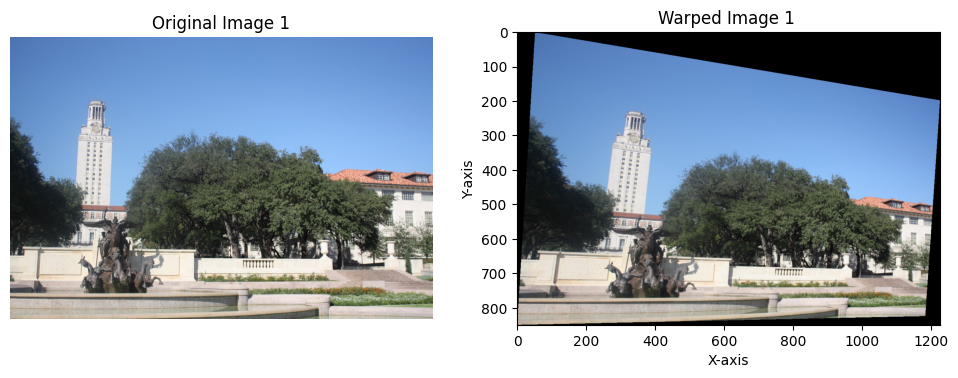

In [38]:
warped_img1_inverse = inverse_warp_image(img1, H)

# Show the original and warped images
plt.figure(figsize=(12, 6))

# Show the original Image 1
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')
plt.axis('off')

# Show the warped image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_img1_inverse, cv2.COLOR_BGR2RGB))
plt.title('Warped Image 1 ')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.show()


In [39]:
def merge_images(img1, img2, H):
    # Get the dimensions of img1 and img2
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    # Calculate the bounding box of the transformed image (img1) using the homography
    corners_img1 = np.array([[0, 0, 1], [w1, 0, 1], [0, h1, 1], [w1, h1, 1]])
    transformed_corners = H @ corners_img1.T
    transformed_corners /= transformed_corners[2, :]  # Normalize homogeneous coordinates
    min_x1, min_y1 = np.min(transformed_corners[:2], axis=1)
    max_x1, max_y1 = np.max(transformed_corners[:2], axis=1)
    
    # Calculate the new canvas size
    min_x = min(0, min_x1)
    min_y = min(0, min_y1)
    max_x = max(w2, max_x1)
    max_y = max(h2, max_y1)
    
    # Initialize a blank canvas large enough to contain both images
    canvas_width = int(max_x - min_x)
    canvas_height = int(max_y - min_y)
    
    merged_img1 = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    merged_img2 = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    # Offset for the img2 (to fit into the new canvas)
    offset_x2 = int(-min_x)
    offset_y2 = int(-min_y)
    
    merged_img1[offset_y2:offset_y2 + h2, offset_x2:offset_x2 + w2] = img2
    merged_img2[offset_y2:offset_y2 + h2, offset_x2:offset_x2 + w2] = img2

    # Forward warp img1 into the new canvas
    warped_img1 = forward_warp_image( img1,H)
    warped_img2 = inverse_warp_image( img1,H)
    
    for y in range(warped_img1.shape[0]):
        for x in range(warped_img1.shape[1]):
            # Ensure coordinates are within canvas bounds
            if 0 <= y < canvas_height and 0 <= x < canvas_width:
                if np.any(warped_img1[y, x]):  # If the pixel is not black
                    merged_img1[y, x] = warped_img1[y, x]

    # Overlay the inverse warped image onto merged_img2
    for y in range(warped_img2.shape[0]):
        for x in range(warped_img2.shape[1]):
            if 0 <= y < canvas_height and 0 <= x < canvas_width:
                if np.any(warped_img2[y, x]):  # If the pixel is not black
                    merged_img2[y, x] = warped_img2[y, x]

    return merged_img1, merged_img2

1227 850


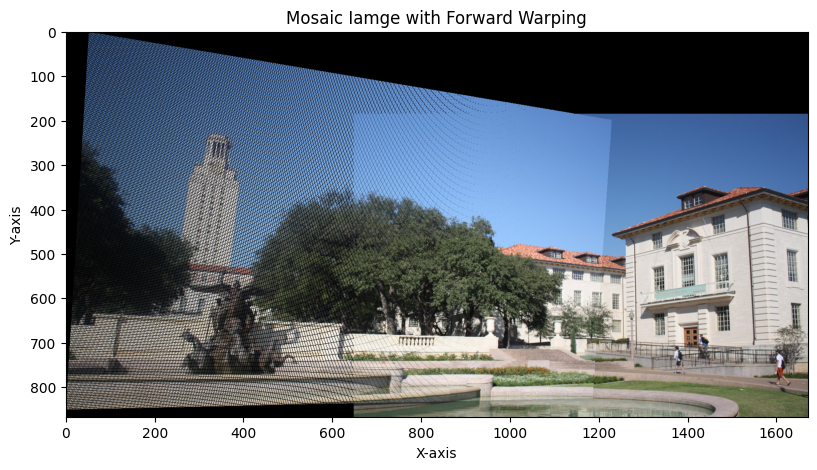

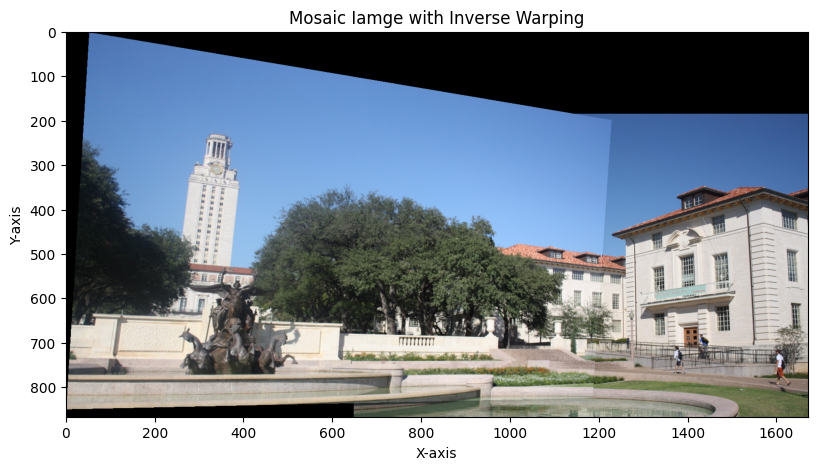

In [ ]:
merged_img1,merged_img2 = merge_images(img1, img2, H)

# Display the merged result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img1, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Forward Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img2, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Inverse Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Another Example


In [43]:
image1_path = "img1.png"
image2_path = "img2.png"
img1_ex = cv2.imread(image1_path, cv2.IMREAD_COLOR)
img2_ex= cv2.imread(image2_path, cv2.IMREAD_COLOR)

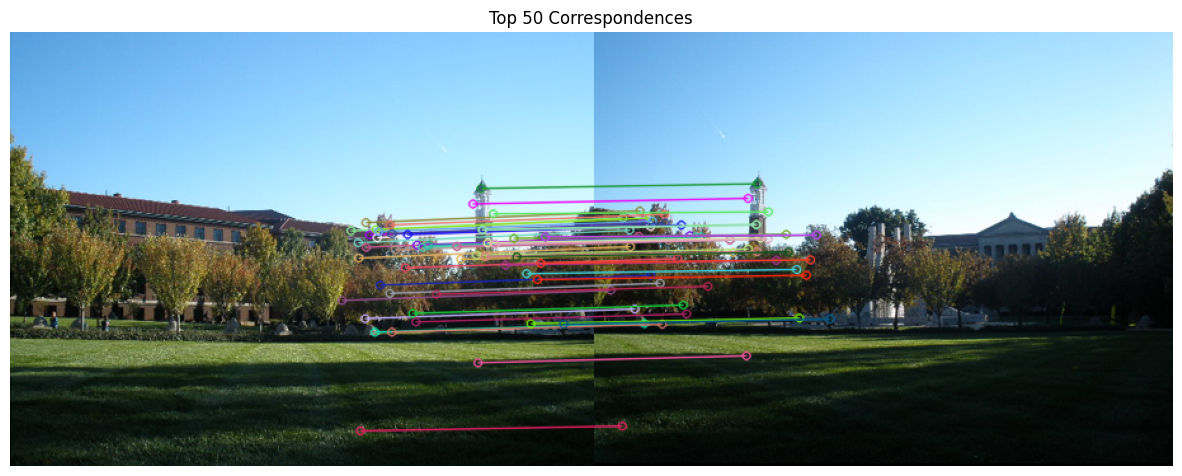

In [44]:
keypoints1_ex , keypoints2_ex , good_matches_ex = find_good_matches(img1_ex, img2_ex)

# To draw and display the matches:
img_matches = cv2.drawMatches(
    img1_ex, keypoints1_ex, img2_ex, keypoints2_ex, good_matches_ex, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Top 50 Correspondences')
plt.show()

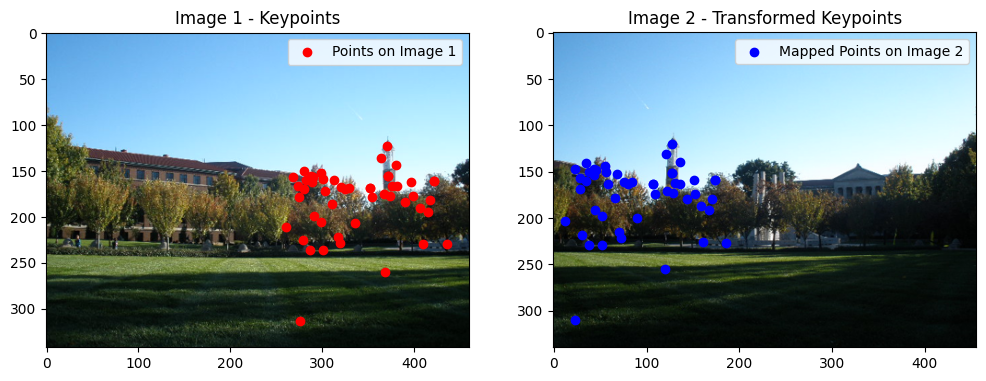

In [48]:
# Extract the matched points
pts1_ex = np.float32([keypoints1_ex[m.queryIdx].pt for m in good_matches_ex])
pts2_ex = np.float32([keypoints2_ex[m.trainIdx].pt for m in good_matches_ex])

# Compute the homography matrix using the function
H_ex = compute_homography(pts1_ex, pts2_ex)

# Apply the homography to transform points from the first image to the second image
transformed_pts_ex = apply_homography(H_ex, pts1_ex)

# Visualize the results: plot the points on both images
plt.figure(figsize=(12, 6))

# Show Image 1 with points
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_ex, cv2.COLOR_BGR2RGB))
plt.scatter(pts1_ex[:, 0], pts1_ex[:, 1], color='red', label='Points on Image 1')
plt.title('Image 1 - Keypoints')
plt.legend()

# Show Image 2 with the transformed points (from Image 1)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_b, cv2.COLOR_BGR2RGB))
plt.scatter(transformed_pts_ex[:, 0], transformed_pts_ex[:, 1], color='blue', label='Mapped Points on Image 2')
plt.title('Image 2 - Transformed Keypoints')
plt.legend()
plt.show()

526 394


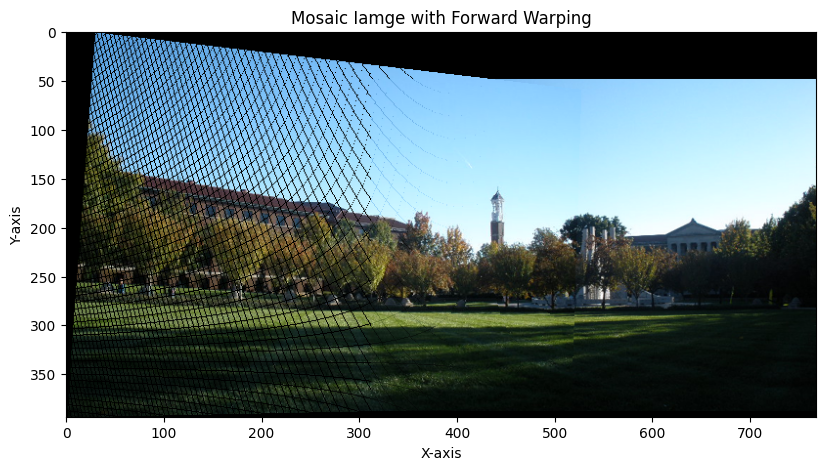

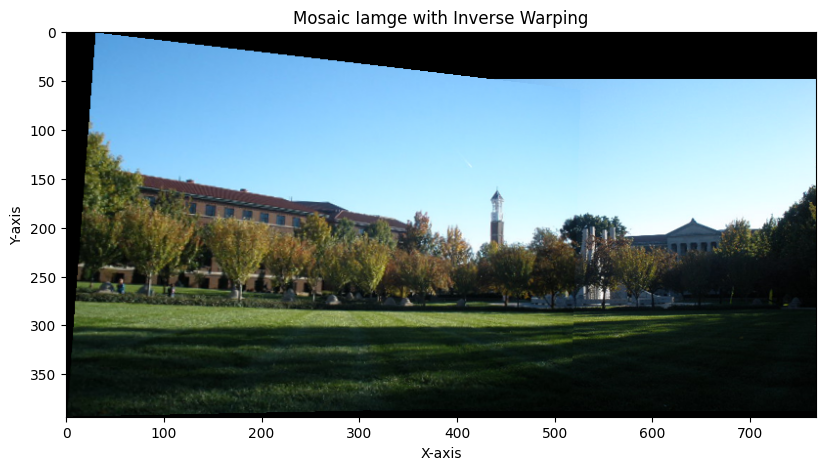

In [50]:
merged_img1_ex,merged_img2_ex = merge_images(img1_ex, img2_ex, H_ex)

# Display the merged result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img1_ex, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Forward Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img2_ex, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Inverse Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Bonus


In [ ]:
image1_path = "shanghai-22.png"
image2_path = "shanghai-21.png"
img1_b = cv2.imread(image1_path, cv2.IMREAD_COLOR)
img2_b = cv2.imread(image2_path, cv2.IMREAD_COLOR)

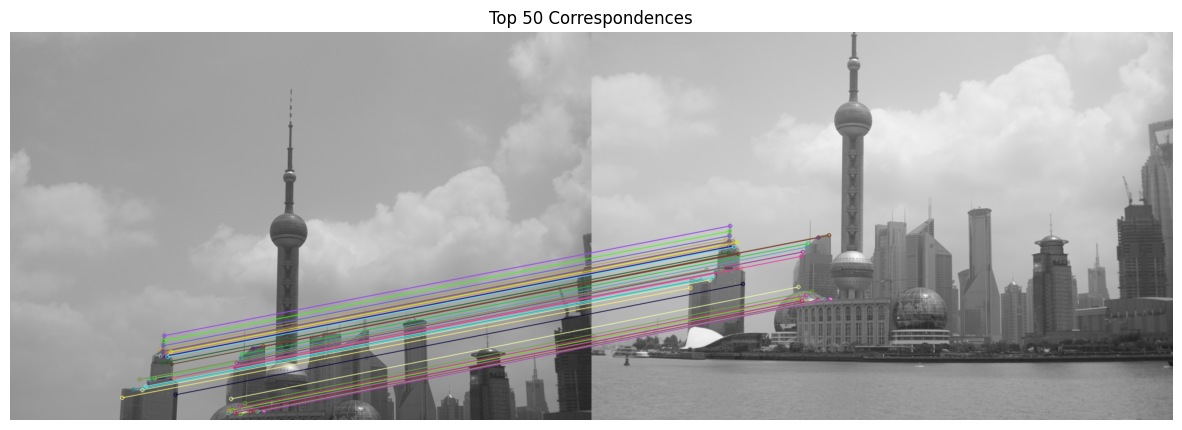

In [ ]:
keypoints1_b1 , keypoints2_b1 , good_matches_b1 = find_good_matches(img1_b, img2_b)

# To draw and display the matches:
img_matches = cv2.drawMatches(
    img1_b, keypoints1_b1, img2_b, keypoints2_b1, good_matches_b1, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Top 50 Correspondences')
plt.show()


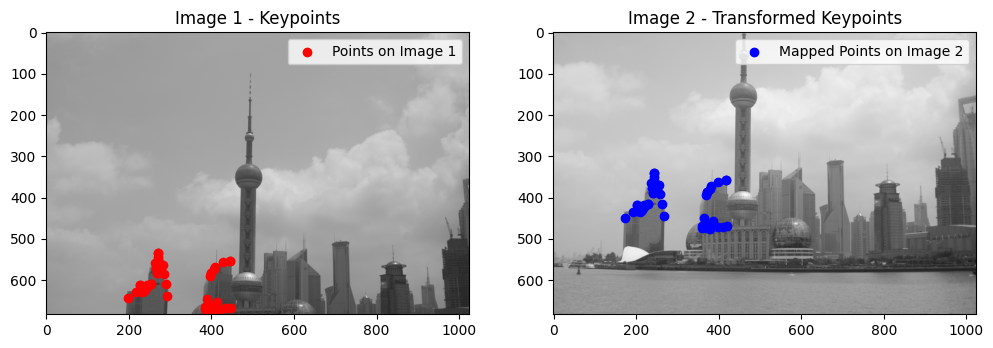

In [ ]:
# Extract the matched points
pts1_b1 = np.float32([keypoints1_b1[m.queryIdx].pt for m in good_matches_b1])
pts2_b1 = np.float32([keypoints2_b1[m.trainIdx].pt for m in good_matches_b1])

# Compute the homography matrix using the function
H_b1 = compute_homography(pts1_b1, pts2_b1)

# Apply the homography to transform points from the first image to the second image
transformed_pts_b1 = apply_homography(H_b1, pts1_b1)

# Visualize the results: plot the points on both images
plt.figure(figsize=(12, 6))

# Show Image 1 with points
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_b, cv2.COLOR_BGR2RGB))
plt.scatter(pts1_b1[:, 0], pts1_b1[:, 1], color='red', label='Points on Image 1')
plt.title('Image 1 - Keypoints')
plt.legend()

# Show Image 2 with the transformed points (from Image 1)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_b, cv2.COLOR_BGR2RGB))
plt.scatter(transformed_pts_b1[:, 0], transformed_pts_b1[:, 1], color='blue', label='Mapped Points on Image 2')
plt.title('Image 2 - Transformed Keypoints')
plt.legend()
plt.show()

1061 711


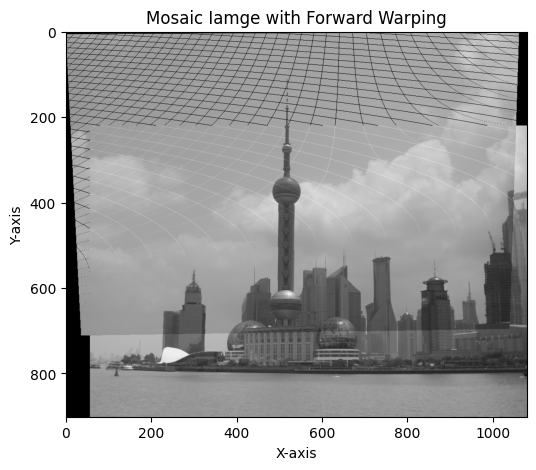

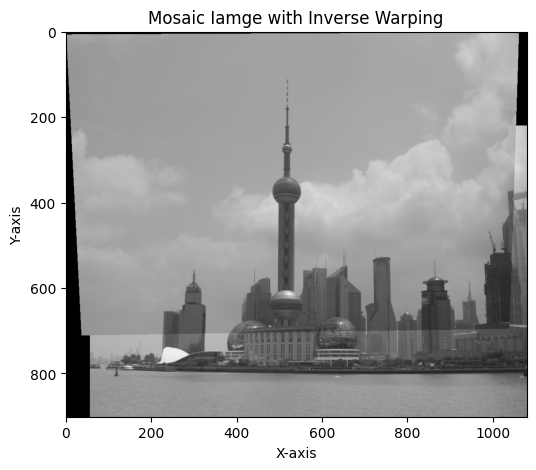

In [ ]:
merged_img1_b1,merged_img2_b1 = merge_images(img1_b, img2_b, H_b1)

# Display the merged result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img1_b1, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Forward Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img2_b1, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Inverse Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
image3_path = "shanghai-23.png"
img12_b = merged_img2_b1
img3_b = cv2.imread(image3_path, cv2.IMREAD_COLOR)

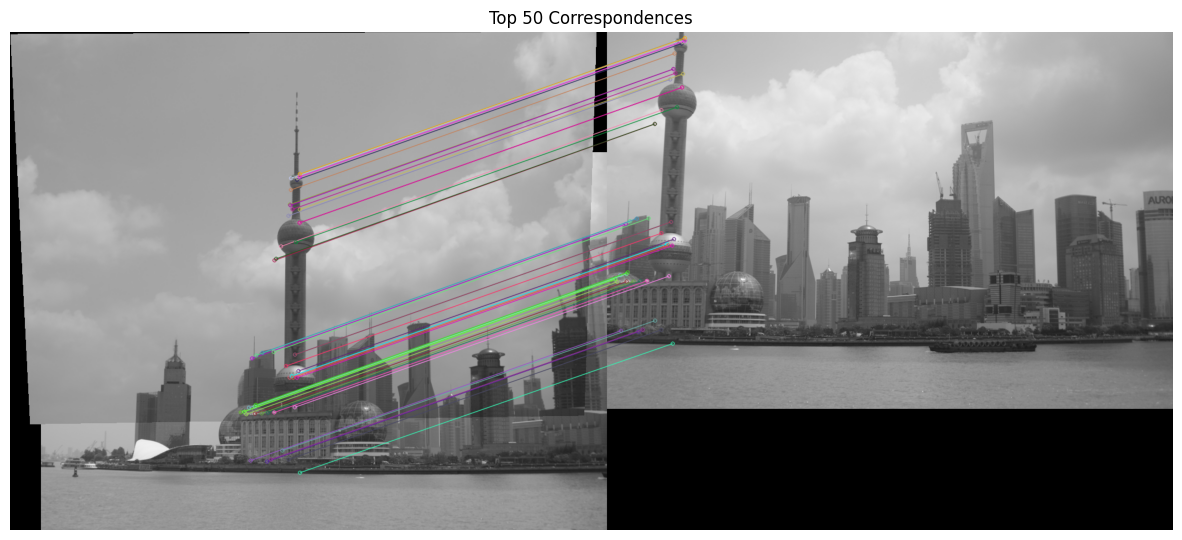

In [ ]:
keypoints1_b2 , keypoints2_b2 , good_matches_b2 = find_good_matches(img12_b, img3_b)

# To draw and display the matches:
img_matches = cv2.drawMatches(
    img12_b, keypoints1_b2, img3_b, keypoints2_b2, good_matches_b2, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Top 50 Correspondences')
plt.show()


Computed Homography Matrix:
[[ 1.35059089e+00 -8.10199718e-02 -5.95823141e+02]
 [ 1.97898033e-01  1.25048024e+00 -1.84549652e+02]
 [ 3.49124112e-04  7.82145742e-06  1.00000000e+00]]


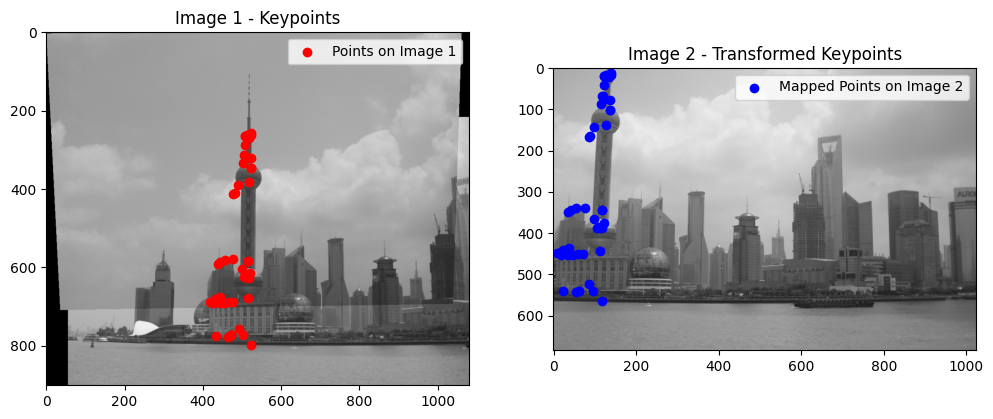

In [ ]:
# Extract the matched points
pts1_b2 = np.float32([keypoints1_b2[m.queryIdx].pt for m in good_matches_b2])
pts2_b2 = np.float32([keypoints2_b2[m.trainIdx].pt for m in good_matches_b2])

# Compute the homography matrix using the function
H_b2 = compute_homography(pts1_b2, pts2_b2)
print("Computed Homography Matrix:")
print(H)


# Apply the homography to transform points from the first image to the second image
transformed_pts_b2 = apply_homography(H_b2, pts1_b2)

# Visualize the results: plot the points on both images
plt.figure(figsize=(12, 6))

# Show Image 1 with points
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img12_b, cv2.COLOR_BGR2RGB))
plt.scatter(pts1_b2[:, 0], pts1_b2[:, 1], color='red', label='Points on Image 1')
plt.title('Image 1 - Keypoints')
plt.legend()

# Show Image 2 with the transformed points (from Image 1)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img3_b, cv2.COLOR_BGR2RGB))
plt.scatter(transformed_pts_b2[:, 0], transformed_pts_b2[:, 1], color='blue', label='Mapped Points on Image 2')
plt.title('Image 2 - Transformed Keypoints')
plt.legend()
plt.show()

1171 1007


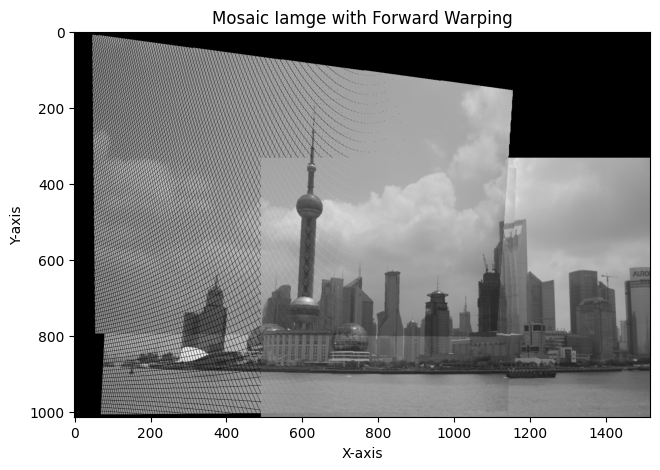

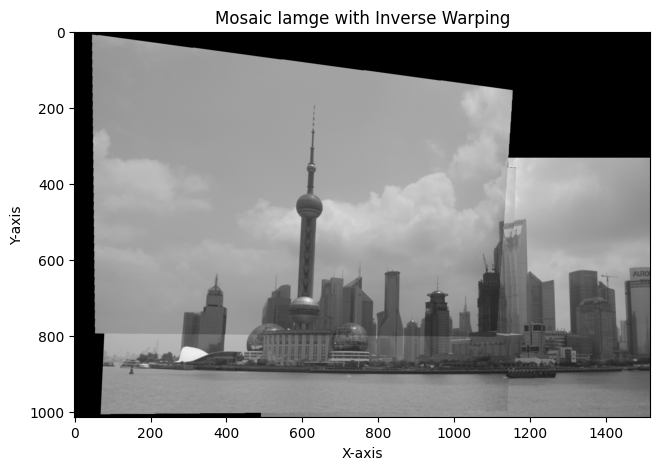

In [ ]:
merged_img1_b2,merged_img2_b2 = merge_images(img12_b, img3_b, H_b2)

# Display the merged result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img1_b2, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Forward Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(merged_img2_b2, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Iamge with Inverse Warping')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()